In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats, zscore
from scipy.special import logit
import matplotlib.pyplot as plt
from matplotlib import rcParams
from seaborn import jointplot, scatterplot
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_q7gzehdw.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Preallocating 10619/11178 Mb (0.950000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:60:00.0)


In [2]:
dnase_regression = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/model_11_hg19.hdf5', compile=False)
dnase_classifier = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/classification_model_3.hdf5', compile=False)
mpra_regression = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_mpra_training/model_8.hdf5', compile=False)

In [ ]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")

In [3]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [ ]:
dnase_regression_ref_scores = dnase_regression.predict(tewhey_ref_sequences)
dnase_regression_alt_scores = dnase_regression.predict(tewhey_alt_sequences)

dnase_classifier_ref_scores = logit(dnase_classifier.predict_proba(tewhey_ref_sequences))
dnase_classifier_alt_scores = logit(dnase_classifier.predict_proba(tewhey_alt_sequences))

mpra_regression_ref_scores = mpra_regression.predict(tewhey_ref_sequences)
mpra_regression_alt_scores = mpra_regression.predict(tewhey_alt_sequences)

In [ ]:
np.save("dnase_regression_ref_scores.npy", dnase_regression_ref_scores)
np.save("dnase_regression_alt_scores.npy", dnase_regression_alt_scores)
np.save("dnase_classifier_ref_scores.npy", dnase_classifier_ref_scores)
np.save("dnase_classifier_alt_scores.npy", dnase_classifier_alt_scores)
np.save("mpra_regression_ref_scores.npy", mpra_regression_ref_scores)
np.save("mpra_regression_alt_scores.npy", mpra_regression_alt_scores)

In [4]:
dnase_regression_ref_scores = np.load("dnase_regression_ref_scores.npy")
dnase_regression_alt_scores = np.load("dnase_regression_alt_scores.npy")
dnase_classifier_ref_scores = np.load("dnase_classifier_ref_scores.npy")
dnase_classifier_alt_scores = np.load("dnase_classifier_alt_scores.npy")
mpra_regression_ref_scores  = np.load("mpra_regression_ref_scores.npy")
mpra_regression_alt_scores  = np.load("mpra_regression_alt_scores.npy")

In [5]:
tewhey_snp_info["Ref.Dnase.Regression"] = dnase_regression_ref_scores
tewhey_snp_info["Alt.Dnase.Regression"] = dnase_regression_alt_scores
tewhey_snp_info["Ref.Dnase.Classifier"] = dnase_classifier_ref_scores
tewhey_snp_info["Alt.Dnase.Classifier"] = dnase_classifier_alt_scores
tewhey_snp_info["Ref.MPRA.Regression"] = mpra_regression_ref_scores
tewhey_snp_info["Alt.MPRA.Regression"] = mpra_regression_alt_scores
tewhey_snp_info["max.allele.logPadj"] = tewhey_snp_info[["C.A.logPadj", "C.B.logPadj"]].max(axis=1)

In [6]:
tewhey_seq_info = pd.DataFrame()

In [7]:
tewhey_seq_info["Dnase.Regression"] = np.concatenate((dnase_regression_ref_scores, dnase_regression_alt_scores)).flatten()
tewhey_seq_info["Dnase.Classifier"] = np.concatenate((dnase_classifier_ref_scores, dnase_classifier_alt_scores)).flatten()
tewhey_seq_info["MPRA.Regression"]  = np.concatenate((mpra_regression_ref_scores, mpra_regression_alt_scores)).flatten()
tewhey_seq_info["log2FC"] = pd.concat([tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["C.B.log2FC"]]).tolist()
tewhey_seq_info["chr"] = pd.concat([tewhey_snp_info["chr"], tewhey_snp_info["chr"]]).tolist()
tewhey_seq_info["active"] = pd.concat([tewhey_snp_info["max.allele.logPadj"]> -np.log10(0.01), tewhey_snp_info["max.allele.logPadj"] > -np.log10(0.01)]).tolist()
tewhey_seq_info["Ctrl.mean"] = pd.concat([tewhey_snp_info["C.A.ctrl.mean"], tewhey_snp_info["C.B.ctrl.mean"]]).tolist()

In [8]:
trainChrs = [17, 11, 19, 12, 5, 22, 9, 21]
validChrs = [3, 7]
testChrs = [1, 6, 10, 4, 2, 16, 20, 15, 8, 14, 18, 13]

In [9]:
tewhey_seq_info["Set"] = tewhey_seq_info["chr"].isin(trainChrs)*0 + tewhey_seq_info["chr"].isin(validChrs)*1 + tewhey_seq_info["chr"].isin(testChrs)*2

In [10]:
tewhey_seq_info = tewhey_seq_info.sample(frac=1)

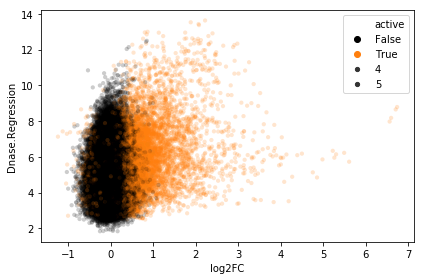

In [440]:
scatterplot(tewhey_seq_info["log2FC"], tewhey_seq_info["Dnase.Regression"], size=5, alpha=0.2, linewidth=0, hue=tewhey_seq_info["active"], palette=['k', 'C1'])
plt.savefig("dnase_regression_rna_over_plasmid_vs_predicted.svg")

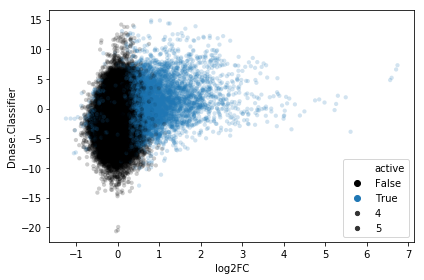

In [441]:
scatterplot(tewhey_seq_info["log2FC"], tewhey_seq_info["Dnase.Classifier"], size=5, alpha=0.2, linewidth=0, hue=tewhey_seq_info["active"], palette=['k', 'C0'])
plt.savefig("dnase_classifier_rna_over_plasmid_vs_predicted.svg")

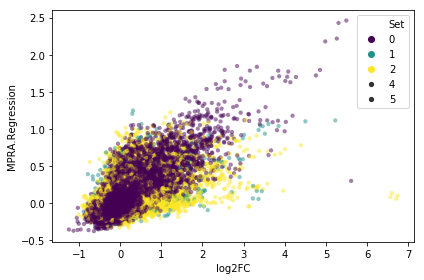

In [436]:
scatterplot("log2FC", "MPRA.Regression", data = tewhey_seq_info, hue = "Set", palette = 'viridis', linewidth=0, size=5, alpha=0.5)
plt.savefig("mpra_regression_rna_over_plasmid_vs_predicted_train_test_valid_colored.svg")

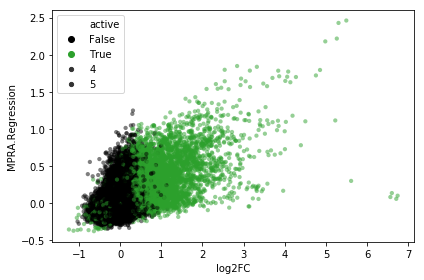

In [442]:
scatterplot("log2FC", "MPRA.Regression", data = tewhey_seq_info, hue = "active", palette = ['k', 'C2'], linewidth=0, size=5, alpha=0.5)
plt.savefig("mpra_regression_rna_over_plasmid_vs_predicted.svg")

/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


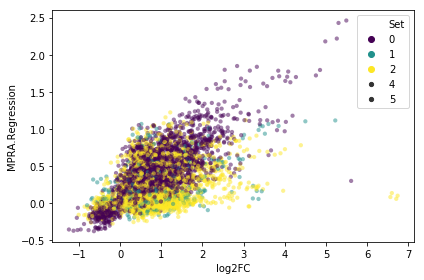

In [434]:
scatterplot("log2FC", "MPRA.Regression", data = tewhey_seq_info_active, hue = "Set", palette = "viridis", size=5, linewidth=0, alpha=0.5)
plt.savefig("mpra_regression_rna_over_plasmid_vs_predicted_only_active_train_test_valid_colored.svg")

In [107]:
print(tewhey_seq_info.drop(["chr", "Set"], axis=1).corr(method="pearson"))
print(tewhey_seq_info.drop(["chr", "Set"], axis=1).corr(method="spearman"))

                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.404503         0.218846   
Dnase.Classifier          0.404503          1.000000         0.393235   
MPRA.Regression           0.218846          0.393235         1.000000   
log2FC                    0.240213          0.257307         0.580939   

                    log2FC  
Dnase.Regression  0.240213  
Dnase.Classifier  0.257307  
MPRA.Regression   0.580939  
log2FC            1.000000  
                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.377722         0.167742   
Dnase.Classifier          0.377722          1.000000         0.370356   
MPRA.Regression           0.167742          0.370356         1.000000   
log2FC                    0.151151          0.215262         0.463754   

                    log2FC  
Dnase.Regression  0.151151  
Dnase.Classifier  0.215262  
MPRA.Regression   0.463754  
log2FC 

In [113]:
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==0][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==0][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.727699
MPRA.Regression  0.727699         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.596338
MPRA.Regression  0.596338         1.000000


In [114]:
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==1][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==1][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.434389
MPRA.Regression  0.434389         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.316751
MPRA.Regression  0.316751         1.000000


In [115]:
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==2][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info.loc[tewhey_seq_info["Set"]==2][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.416004
MPRA.Regression  0.416004         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.332902
MPRA.Regression  0.332902         1.000000


In [11]:
tewhey_snp_info["DNase.Regression.Skew"] = tewhey_snp_info["Alt.Dnase.Regression"] - tewhey_snp_info["Ref.Dnase.Regression"]
tewhey_snp_info["DNase.Classifier.Skew"] = tewhey_snp_info["Alt.Dnase.Classifier"] - tewhey_snp_info["Ref.Dnase.Classifier"]
tewhey_snp_info["MPRA.Regression.Skew"] = tewhey_snp_info["Alt.MPRA.Regression"] - tewhey_snp_info["Ref.MPRA.Regression"]

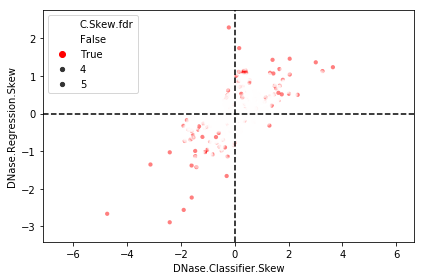

In [422]:
scatterplot(tewhey_snp_info["DNase.Classifier.Skew"], tewhey_snp_info["DNase.Regression.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

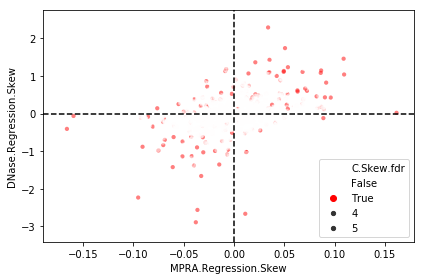

In [426]:
scatterplot(tewhey_snp_info["MPRA.Regression.Skew"], tewhey_snp_info["DNase.Regression.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

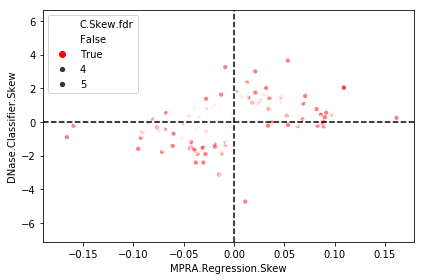

In [424]:
scatterplot(tewhey_snp_info["MPRA.Regression.Skew"], tewhey_snp_info["DNase.Classifier.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

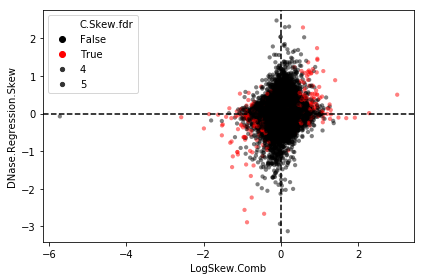

In [415]:
scatterplot(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["DNase.Regression.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

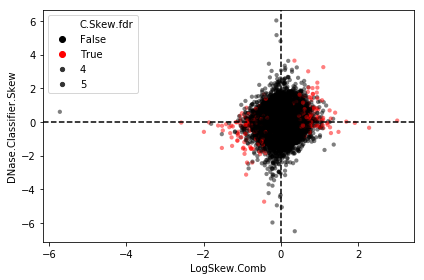

In [416]:
scatterplot(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["DNase.Classifier.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

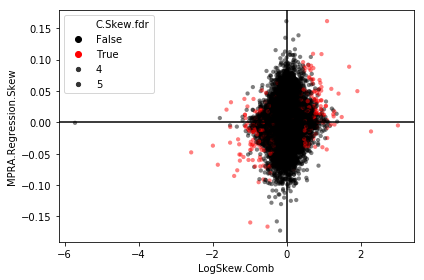

In [417]:
scatterplot(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["MPRA.Regression.Skew"], hue=tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k')
plt.axvline(c='k')
plt.show()

In [12]:
tewhey_snp_info_active = tewhey_snp_info.loc[tewhey_snp_info["max.allele.logPadj"] > -np.log10(0.01)]

In [13]:
tewhey_seq_info_active = pd.DataFrame()

In [14]:
tewhey_seq_info_active["Dnase.Regression"] = np.concatenate((tewhey_snp_info_active["Ref.Dnase.Regression"], tewhey_snp_info_active["Alt.Dnase.Regression"])).flatten()
tewhey_seq_info_active["Dnase.Classifier"] = np.concatenate((tewhey_snp_info_active["Ref.Dnase.Classifier"], tewhey_snp_info_active["Alt.Dnase.Classifier"])).flatten()
tewhey_seq_info_active["MPRA.Regression"]  = np.concatenate((tewhey_snp_info_active["Ref.MPRA.Regression" ], tewhey_snp_info_active["Alt.MPRA.Regression"])).flatten()
tewhey_seq_info_active["log2FC"] = pd.concat([tewhey_snp_info_active["C.A.log2FC"], tewhey_snp_info_active["C.B.log2FC"]]).tolist()
tewhey_seq_info_active["chr"] = pd.concat([tewhey_snp_info_active["chr"], tewhey_snp_info_active["chr"]]).tolist()

In [15]:
trainChrs = [17, 11, 19, 12, 5, 22, 9, 21]
validChrs = [3, 7]
testChrs = [1, 6, 10, 4, 2, 16, 20, 15, 8, 14, 18, 13]

In [16]:
tewhey_seq_info_active["Set"] = tewhey_seq_info_active["chr"].isin(trainChrs)*0 + tewhey_seq_info_active["chr"].isin(validChrs)*1 + tewhey_seq_info_active["chr"].isin(testChrs)*2

In [17]:
tewhey_seq_info_active = tewhey_seq_info_active.sample(frac=1)

In [19]:
print(tewhey_seq_info_active.drop(["chr", "Set"], axis=1).corr(method="pearson"))
print(tewhey_seq_info_active.drop(["chr", "Set"], axis=1).corr(method="spearman"))

                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.438338         0.198875   
Dnase.Classifier          0.438338          1.000000         0.347665   
MPRA.Regression           0.198875          0.347665         1.000000   
log2FC                    0.261630          0.241324         0.553476   

                    log2FC  
Dnase.Regression  0.261630  
Dnase.Classifier  0.241324  
MPRA.Regression   0.553476  
log2FC            1.000000  
                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.400055         0.152736   
Dnase.Classifier          0.400055          1.000000         0.371836   
MPRA.Regression           0.152736          0.371836         1.000000   
log2FC                    0.242989          0.220801         0.427265   

                    log2FC  
Dnase.Regression  0.242989  
Dnase.Classifier  0.220801  
MPRA.Regression   0.427265  
log2FC 

In [20]:
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==0][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==0][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.754586
MPRA.Regression  0.754586         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.637259
MPRA.Regression  0.637259         1.000000


In [21]:
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==1][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==1][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.413243
MPRA.Regression  0.413243         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.218661
MPRA.Regression  0.218661         1.000000


In [22]:
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==2][["log2FC", "MPRA.Regression"]].corr(method="pearson"))
print(tewhey_seq_info_active.loc[tewhey_seq_info_active["Set"]==2][["log2FC", "MPRA.Regression"]].corr(method="spearman"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.342511
MPRA.Regression  0.342511         1.000000
                   log2FC  MPRA.Regression
log2FC           1.000000         0.275263
MPRA.Regression  0.275263         1.000000


In [18]:
tewhey_snp_info_pos = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] > -np.log10(0.01)) & (tewhey_snp_info_active["LogSkew.Comb"]>0)]
tewhey_snp_info_neg = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] > -np.log10(0.01)) & (tewhey_snp_info_active["LogSkew.Comb"]<0)]
tewhey_snp_info_neutral = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] < -np.log10(0.01)) & (np.absolute(tewhey_snp_info_active["LogSkew.Comb"])<0.2)]

In [19]:
def z_with_center(values, center = 0):
    return (values-0)/np.std(values)

In [20]:
plottables =[z_with_center(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_neg["MPRA.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna()).tolist(),             
             z_with_center(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_pos["MPRA.Regression.Skew"].dropna()).tolist()]

In [23]:
print(ttest_1samp(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["DNase.Classifier.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-6.818236208233338, pvalue=1.0220120469102409e-10)
Ttest_1sampResult(statistic=0.5859388387212296, pvalue=0.5579696570288868)
Ttest_1sampResult(statistic=6.845072841164581, pvalue=9.359588054218726e-11)
Ttest_indResult(statistic=-6.835506688294088, pvalue=8.215410894026548e-11)
Ttest_indResult(statistic=6.641354931622591, pvalue=2.5746104070289237e-10)


In [24]:
print(ttest_1samp(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-6.909694596083259, pvalue=6.074263721229715e-11)
Ttest_1sampResult(statistic=0.21913725502898831, pvalue=0.8265610407425052)
Ttest_1sampResult(statistic=7.912617481255033, pvalue=1.749580251177921e-13)
Ttest_indResult(statistic=-6.898432215292717, pvalue=6.039117873259727e-11)
Ttest_indResult(statistic=7.817517020047875, pvalue=2.7093979220750555e-13)


In [25]:
print(ttest_1samp(tewhey_snp_info_neg["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neg["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neg["MPRA.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_pos["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_pos["MPRA.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neutral["MPRA.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-8.130092543239956, pvalue=4.102115010919914e-14)
Ttest_1sampResult(statistic=-2.9299597170311067, pvalue=0.0034208043581689484)
Ttest_1sampResult(statistic=7.761504562221097, pvalue=4.381521880690523e-13)
Ttest_indResult(statistic=-7.336062240746876, pvalue=4.000413281868283e-12)
Ttest_indResult(statistic=8.217407553289982, pvalue=1.9136605746731546e-14)


In [27]:
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_neg["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_neg["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_indResult(statistic=-1.861802798941484, pvalue=0.06345789346163513)


In [28]:
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_pos["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_pos["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_indResult(statistic=1.6074074468824584, pvalue=0.10891407105171891)


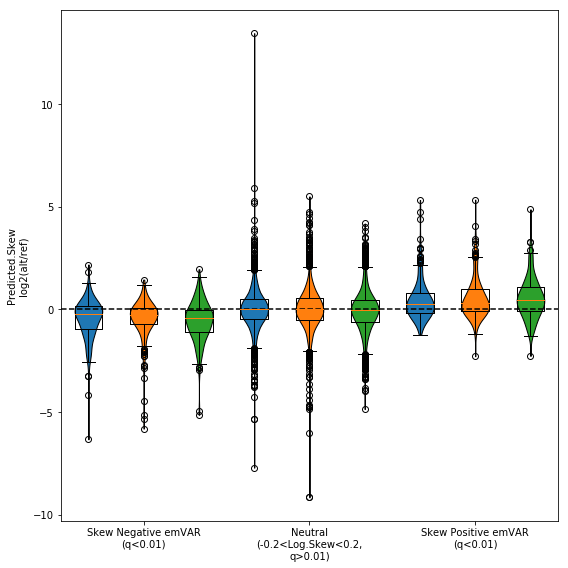

In [432]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=plottables,
                               showmedians=False,showextrema=False)

for i in range(0,9,3):
    parts['bodies'][i].set_facecolor('C0')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)
for i in range(1,9,3):   
    parts['bodies'][i].set_facecolor('C1')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)    
for i in range(2,9,3):
    parts['bodies'][i].set_facecolor('C2')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)   

plt.boxplot(plottables)


plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(2,9,3), labels = ["Skew Negative emVAR\n(q<0.01)", "Neutral\n(-0.2<Log.Skew<0.2,\nq>0.01)", "Skew Positive emVAR\n(q<0.01)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.savefig("compare_models_q_0.01_emVAR_violin.svg")
#print(ttest_1samp(train_tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
#print(ttest_1samp(train_tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
#print(ttest_1samp(train_tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
#print(ttest_ind_from_stats(np.mean(train_tewhey_snp_info_neg["Predicted.skew"]),
#                     np.std(train_tewhey_snp_info_neg["Predicted.skew"]),
#                     len(train_tewhey_snp_info_neg["Predicted.skew"].tolist()),
#                     np.mean(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                     np.std(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                     len(train_tewhey_snp_info_neutral["Predicted.skew"].tolist()),
#                     equal_var=False))
#print(ttest_ind_from_stats(np.mean(train_tewhey_snp_info_pos["Predicted.skew"]),
#                    np.std(train_tewhey_snp_info_pos["Predicted.skew"]),
#                    len(train_tewhey_snp_info_pos["Predicted.skew"].tolist()),
#                    np.mean(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                    np.std(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                    len(train_tewhey_snp_info_neutral["Predicted.skew"].tolist()),
#                    equal_var=False))

In [310]:
print((tewhey_snp_info_pos.loc[tewhey_snp_info_pos["DNase.Classifier.Skew"]>0]).shape)
print((tewhey_snp_info_neg.loc[tewhey_snp_info_neg["DNase.Classifier.Skew"]<0]).shape)

print((tewhey_snp_info_pos.loc[tewhey_snp_info_pos["DNase.Regression.Skew"]>0]).shape)
print((tewhey_snp_info_neg.loc[tewhey_snp_info_neg["DNase.Regression.Skew"]<0]).shape)

print((tewhey_snp_info_pos.loc[tewhey_snp_info_pos["MPRA.Regression.Skew"]>0]).shape)
print((tewhey_snp_info_neg.loc[tewhey_snp_info_neg["MPRA.Regression.Skew"]<0]).shape)

(134, 38)
(144, 38)
(137, 38)
(147, 38)
(145, 38)
(154, 38)


In [334]:
dnase_regression_accuracies = []
dnase_classifier_accuracies = []
mpra_regression_accuracies = []
naive_accuracies = []
q_cutoffs = np.logspace(-3.5,-1,50)

for q_cutoff in q_cutoffs:
    tewhey_snp_info_pos = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] > -np.log10(q_cutoff)) & (tewhey_snp_info_active["LogSkew.Comb"]>0)]
    tewhey_snp_info_neg = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] > -np.log10(q_cutoff)) & (tewhey_snp_info_active["LogSkew.Comb"]<0)]
    tewhey_snp_info_neutral = tewhey_snp_info_active[(tewhey_snp_info_active["C.Skew.fdr"] < -np.log10(q_cutoff)) & (np.absolute(tewhey_snp_info_active["LogSkew.Comb"])<0.2)]
    
    dnase_classifier_pos_accurate = (tewhey_snp_info_pos.loc[tewhey_snp_info_pos["DNase.Classifier.Skew"]>0]).shape[0]
    dnase_classifier_neg_accurate = (tewhey_snp_info_neg.loc[tewhey_snp_info_neg["DNase.Classifier.Skew"]<0]).shape[0]
    
    dnase_regression_pos_accurate = (tewhey_snp_info_pos.loc[tewhey_snp_info_pos["DNase.Regression.Skew"]>0]).shape[0]
    dnase_regression_neg_accurate = (tewhey_snp_info_neg.loc[tewhey_snp_info_neg["DNase.Regression.Skew"]<0]).shape[0]

    mpra_regression_pos_accurate = (tewhey_snp_info_pos.loc[tewhey_snp_info_pos["MPRA.Regression.Skew"]>0]).shape[0]
    mpra_regression_neg_accurate = (tewhey_snp_info_neg.loc[tewhey_snp_info_neg["MPRA.Regression.Skew"]<0]).shape[0]

    
    total = tewhey_snp_info_pos.shape[0] + tewhey_snp_info_neg.shape[0]
    print(q_cutoff,tewhey_snp_info_pos.shape[0], tewhey_snp_info_neg.shape[0], total)
    
    dnase_classifier_accuracy = 1.0*(dnase_classifier_pos_accurate+dnase_classifier_neg_accurate)/total
    dnase_regression_accuracy = 1.0*(dnase_regression_pos_accurate+dnase_regression_neg_accurate)/total
    mpra_regression_accuracy = 1.0*(mpra_regression_pos_accurate+mpra_regression_neg_accurate)/total
    naive_accuracy = 1.0*max(tewhey_snp_info_pos.shape[0], tewhey_snp_info_neg.shape[0])/total
    
    dnase_classifier_accuracies.append(dnase_classifier_accuracy)
    dnase_regression_accuracies.append(dnase_regression_accuracy)
    mpra_regression_accuracies.append(mpra_regression_accuracy)
    naive_accuracies.append(naive_accuracy)

0.00031622776601683794 23 17 40
0.00035564803062231287 25 18 43
0.0003999823395608933 27 21 48
0.0004498432668969444 27 22 49
0.0005059197488435823 33 28 61
0.0005689866029018299 34 34 68
0.0006399152336349266 35 35 70
0.0007196856730011522 39 37 76
0.0008094001216083124 41 37 78
0.0009102981779915217 45 41 86
0.0010237739663395847 53 47 100
0.0011513953993264481 58 50 108
0.0012949258422052632 68 60 128
0.0014563484775012444 70 67 137
0.0016378937069540646 74 73 147
0.0018420699693267163 78 83 161
0.0020716983998953077 88 87 175
0.002329951810515372 92 90 182
0.0026203985288583485 104 100 204
0.0029470517025518097 111 108 219
0.003314424749466425 118 112 230
0.003727593720314938 124 116 240
0.004192267435236918 128 119 247
0.004714866363457394 133 126 259
0.005302611335911987 142 142 284
0.005963623316594642 158 157 315
0.006707035611184306 162 163 325
0.007543120063354623 168 170 338
0.008483428982440725 185 193 378
0.009540954763499945 194 204 398
0.010730309405261566 207 211 418
0.

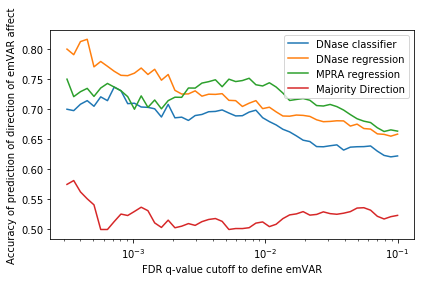

In [429]:
plt.plot(q_cutoffs, dnase_classifier_accuracies, c='C0', label = 'DNase classifier')
plt.plot(q_cutoffs, dnase_regression_accuracies, c='C1', label = 'DNase regression')
plt.plot(q_cutoffs, mpra_regression_accuracies, c='C2', label = 'MPRA regression')
plt.plot(q_cutoffs, naive_accuracies, c='C3', label = 'Majority Direction')
plt.xlabel("FDR q-value cutoff to define emVAR")
plt.ylabel("Accuracy of prediction of direction of emVAR affect")
plt.xscale("log")
plt.legend()
plt.savefig("compare_models_different_q_cutoffs_emvar.svg")

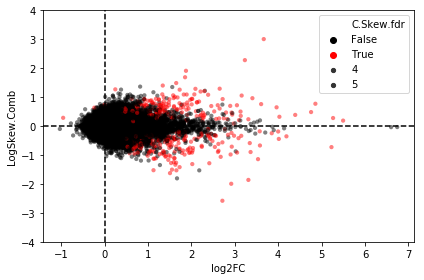

In [428]:
scatterplot(tewhey_snp_info[["C.A.log2FC", "C.B.log2FC"]].max(axis=1), tewhey_snp_info["LogSkew.Comb"], hue = (tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.01)), linewidth=0, palette = ['k', 'r'], alpha=0.5, size=5)

plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.xlabel("log2FC")
plt.ylim([-4,4])
plt.savefig("tewhey_rna_over_plasmid_vs_skew.svg")

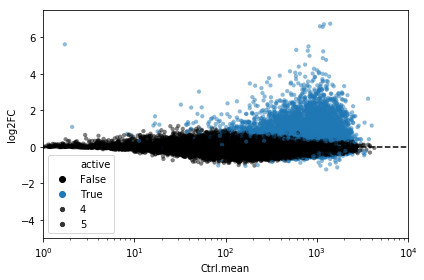

In [439]:
scatterplot(tewhey_seq_info["Ctrl.mean"], tewhey_seq_info["log2FC"], hue = tewhey_seq_info["active"], linewidth=0, palette = ['k', 'C0'], alpha=0.5, size=5)
plt.ylim([-5,7.5])
plt.xscale("log")
plt.xlim([1,1e4])
plt.axhline(c='k', linestyle='--')
plt.savefig("tewhey_plasmid_vs_rna_over_plasmid.svg")